In [1]:
import node 

GPU


In [2]:
import cupy as np 

In [3]:
# Image shape
rows = 32
cols = 32

In [4]:
base = 64
num_in_ch = 32
num_out_ch = 1

In [5]:
epoch = 301

In [6]:
def initialize(layers):
    """
    ジェネレーターとディスクリミネーターの重みを
    
    畳み込み層: 平均0.0、分散0.02
    バッチ正則化層: 平均1.0、分散0.02
    
    に初期化する
    """
    for layer in layers:
        if repr(layer) == "Conv2D" or repr(layer) == "ConvTranspose2D":
            W = layer.parameters["W"]
            W.value = np.random.normal(0.0, 0.02, size=W.value.shape, dtype=np.float32)
        elif repr(layer) == "BatchNormalization":
            W = layer.parameters["W"]
            W.value = np.random.normal(1.0, 0.02, size=W.value.shape, dtype=np.float32)

In [7]:
class Generator(node.Network):
    
    def __init__(self, base=64, num_in_ch=100, num_out_ch=3):
        """
        引数
            base: チャンネル数の基数
            num_in_ch: ノイズ(入力)のチャンネル数
            num_out_ch: 出力のチャンネル数
        """
        
        super(Generator, self).__init__()
        
        self.layers = [
            # Block 1
            node.ConvTranspose2D(num_in_ch, base * 4, 4, 1, 0),
            node.BatchNormalization(base * 4),
            
            # Block 2
            node.ConvTranspose2D(base * 4, base * 2, 4, 2, 1),
            node.BatchNormalization(base * 2),
            
            # Block 3
            node.ConvTranspose2D(base * 2, base, 4, 2, 1),
            node.BatchNormalization(base),
            
            # Block 4
            node.ConvTranspose2D(base, num_out_ch, 4, 2, 1)
        ]
        
    def __call__(self, input):
        hidden = input
        
        # Block 1
        # Output Shape: base * 4 x 4 x 4
        hidden = self.layers[0](hidden)
        hidden = self.layers[1](hidden)
        hidden = hidden.relu()
        
        # Block 2
        # Output Shape: base * 2 x 8 x 8
        hidden = self.layers[2](hidden)
        hidden = self.layers[3](hidden)
        hidden = hidden.relu()
        
        # Block 3
        # Output Shape: base x 16 x 16
        hidden = self.layers[4](hidden)
        hidden = self.layers[5](hidden)
        hidden = hidden.relu()
        
        # Block 4
        # Output Shape: output x 32 x 32
        hidden = self.layers[6](hidden)
        hidden = hidden.tanh()
        
        return hidden
    
generator = Generator(base, num_in_ch, num_out_ch)
generator = generator
initialize(generator.layers)

In [8]:
class Discriminator(node.Network):
    
    def __init__(self, base=64, num_in_ch=3):
        """
        引数
            base: チャンネル数の基数
            num_in_ch: ノイズ(入力)のチャンネル数
        """
        
        super(Discriminator, self).__init__()
        
        self.layers = [
            # Block 1
            node.Conv2D(num_in_ch, base, 4, 2, 1, use_bias=False),
            
            # Block 2
            node.Conv2D(base, base * 2, 4, 2, 1, use_bias=False),
            node.BatchNormalization(base * 2),
            
            # Block 3
            node.Conv2D(base * 2, base * 4, 4, 2, 1, use_bias=False),
            node.BatchNormalization(base * 4),
            
            # Block 4
            node.Conv2D(base * 4, 1, 4, 1, 0, use_bias=False)
        ]
        
    def __call__(self, input):
        hidden = input
        
        # Block 1 
        # Output Shape: base x 16 x 16
        hidden = self.layers[0](hidden)
        hidden = hidden.leaky_relu(0.2)
        
        # Block 2
        # Output Shape: base * 2 x 8 x 8
        hidden = self.layers[1](hidden)
        hidden = self.layers[2](hidden)
        hidden = hidden.leaky_relu(0.2)
        
        # Block 3
        # Output Shape: base * 4 x 4 x 4
        hidden = self.layers[3](hidden)
        hidden = self.layers[4](hidden)
        hidden = hidden.leaky_relu(0.2)
        
        # Block 4 
        # Output Shape: 1 x 1 x 1
        hidden = self.layers[5](hidden)
        hidden = hidden.sigmoid()
        
        return hidden.reshape(input.value.shape[0], -1)
        
discriminator = Discriminator(base, num_out_ch)
discriminator = discriminator
initialize(discriminator.layers)

In [9]:
# optimizers[0]: for generator
# optimizers[1]: for discriminator
optimizers = [
    node.Adam(generator.get_parameters(), 0.0002, beta_1=0.5),
    node.Adam(discriminator.get_parameters(), 0.0002, beta_1=0.5)
]

In [10]:
# targets[0]: valid
# targets[1]: invalid
targets = [
    node.Node(np.ones(shape=[100, 1], dtype=np.float32), no_grad=True),
    node.Node(np.zeros(shape=[100, 1], dtype=np.float32), no_grad=True)
]

In [11]:
def train(true):
    """
    Update generator and discriminator parameters
    
    Arguments
        true: true images from dataset
    """
    # Get input info
    B, _, _, _ = true.value.shape
    
    # losses[0]: for generator
    # losses[1]: for discriminator (true images)
    # losses[2]: for discriminator (fake images)
    losses = [None, None, None]
    
    # Clean gradients
    optimizers[0].zero_grad()
    optimizers[1].zero_grad()
    
    # Update generator parameters
    noise = node.Node(np.random.uniform(0.0, 1.0, size=[B, num_in_ch, 1, 1], dtype=np.float32))
    fake = generator(noise)
    losses[0] = discriminator(fake).binary_cross_entropy(targets[0])
    losses[0].backward()
    optimizers[0]()
    
    # Compute gradients w.r.t discriminator parameters with true images
    optimizers[0].zero_grad()
    optimizers[1].zero_grad()
    losses[1] = discriminator(true).binary_cross_entropy(targets[0])
    losses[1].backward()
    optimizers[1]()
    
    # Compute gradients w.r.t discriminator parameters with fake images
    optimizers[0].zero_grad()
    optimizers[1].zero_grad()
    losses[2] = discriminator(fake).binary_cross_entropy(targets[1])
    losses[2].backward()
    optimizers[1]()
    
    # Return generator and discriminator losses
    return (fake, losses[0].value, losses[1].value + losses[2].value)

In [12]:
# Load MNISt dataset
dataset = node.MNIST(training=True)
dataloader = node.DataLoader(dataset, 100)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(fake, rows=1, cols=5):
    """
    Visualize fake images of generator
    
    Arguments
        fake: fake images of generator
        rows: indicates how many images are plotted along rows
        cols: indicates how many images are plotted along columns
    """
    _, axes = plt.subplots(rows, cols)
    
    # Get fake image info
    _, _, H, W = fake.shape
    
    # Plot fake images one by one along columns
    for i in range(cols):
        axes[i].imshow(fake[i].reshape(H, W), cmap="gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
            
    plt.show()

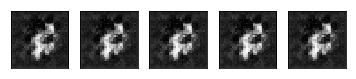

(epoch   0) gen: 4.7881, disc: 0.2445


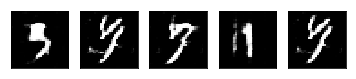

(epoch  30) gen: 5.0418, disc: 0.0886


KeyboardInterrupt: 

In [14]:
for i in range(epoch):
    # metrics[0]: for generator
    # metrics[1]: for discriminator
    metrics = [0, 0]
    
    # Iterate over dataset
    for true, _ in dataloader:
        # Resize input 
        B, _, _, _ = true.value.shape
        true.value = np.pad(true.value, [(0, 0), (0, 0), (2, 2), (2, 2)], "constant")
        fake, gen, disc = train((true - 127.5) / 127.5)
        metrics[0] += np.asnumpy(gen) / len(dataloader)
        metrics[1] += np.asnumpy(disc) / len(dataloader)
        
    if i % 30 == 0:
        visualize(np.asnumpy(fake.value))
        print("(epoch {0:3}) gen: {1:.4f}, disc: {2:.4f}".format(i, *metrics))